In [12]:
import pandas as pd
import pickle
import numpy as np
from collections import ChainMap

import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
# Arguments for 

#   --extract variants
#   --out ukb_1kg_projections
#   --pfile /gpfs/gpfs0/ukb_data/plink/plink
#   --read-freq unphased.qc.acount
#   --score unphased.qc.pca.eigenvec.var 2 3 variance-standardize
#   --score-col-nums 5-24

In [2]:
UKB_TG_PROJECTIONS_PATH = '/trinity/home/s.mishra/1kg/ukb_1kg_projections.sscore'
TG_ANCESTRY_MODEL_PATH = '/trinity/home/s.mishra/1kg/model.pkl'
SUPERPOPULATIONS_OUTPUT_PATH = '/trinity/home/s.mishra/uk-biobank/superpopulations.csv'

In [3]:
superpopulations = {
    0: ['CEU', 'TSI', 'GBR', 'FIN', 'IBS'],
    1: ['GIH', 'PJL', 'BEB', 'STU', 'ITU'],
    2: ['YRI', 'LWK', 'GWD', 'MSL', 'ESN'],
    3: ['CHB', 'JPT', 'CHS', 'CDX', 'KHV', 'CHD'],
    4: ['ASW', 'ACB', 'MXL', 'PUR', 'CLM', 'PEL']
}

superpopulations_map = dict(ChainMap(*[{pop: i for pop in superpopulations[i]} for i in range(5)]))

In [4]:
ukb_tg_projections = pd.read_table(UKB_TG_PROJECTIONS_PATH)
X = ukb_tg_projections.iloc[:, 4:].values
ancestry_model = pickle.load(open(TG_ANCESTRY_MODEL_PATH, 'rb'))
ukb_tg_projections['pred_ancestry'] = ancestry_model.predict(X)
ukb_tg_projections['pred_superpopulation'] = np.vectorize(lambda ancestry: superpopulations_map[ancestry])(ukb_tg_projections.pred_ancestry)
ukb_tg_projections.loc[:, ['IID', 'pred_superpopulation']].to_csv(SUPERPOPULATIONS_OUTPUT_PATH, index=False)

/trinity/home/s.mishra/.conda/envs/fl/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/trinity/home/s.mishra/.conda/envs/fl/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/trinity/home/s.mishra/.conda/envs/fl/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted w

In [41]:
ukb_tg_projections.pred_superpopulation.value_counts()

0    461102
1     10656
2      7309
4      6596
3      2714
Name: pred_superpopulation, dtype: int64

In [45]:
ukb_tg_projections.pred_ancestry.value_counts()

GBR    453581
PJL      8537
TSI      7234
PUR      6161
LWK      4031
YRI      3219
CHB      1560
STU      1191
BEB       928
KHV       875
PEL       435
FIN       287
JPT       279
MSL        54
ESN         5
Name: pred_ancestry, dtype: int64

In [49]:
px.scatter(ukb_tg_projections, x='SCORE1_AVG', y='SCORE2_AVG', color='pred_ancestry').write_html('ancestries.html')
px.scatter(ukb_tg_projections, x='SCORE3_AVG', y='SCORE4_AVG', color='pred_superpopulation').write_html('superpopulations_pc3v4.html')
px.scatter(ukb_tg_projections, x='SCORE1_AVG', y='SCORE2_AVG', color='pred_superpopulation').write_html('superpopulations_pc1v2.html')

In [5]:
probs = ancestry_model.predict_proba(X)

/trinity/home/s.mishra/.conda/envs/fl/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


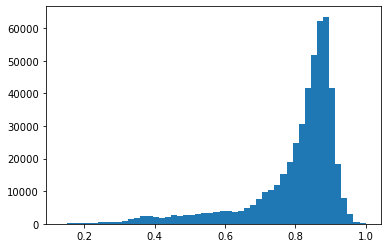

In [13]:
plt.hist(np.amax(probs, axis=1), bins=50);

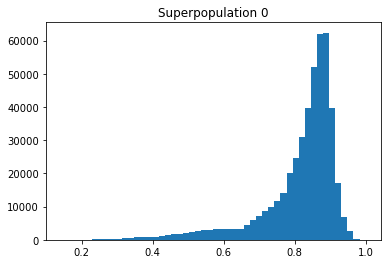

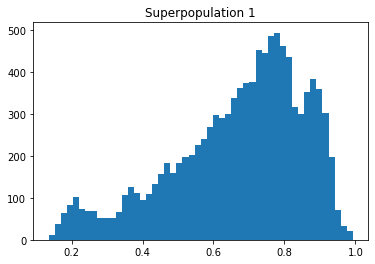

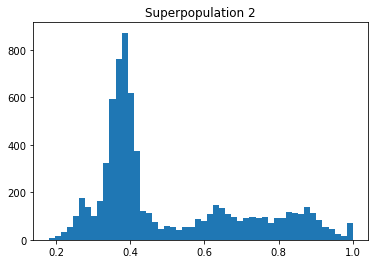

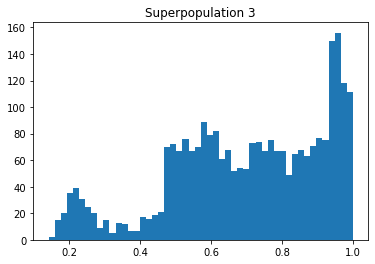

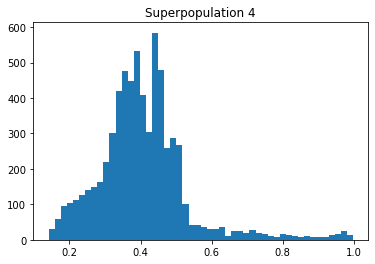

In [17]:
for i in range(5):
    plt.figure()
    plt.title(f"Superpopulation {i}")
    plt.hist(np.amax(probs[ukb_tg_projections.pred_superpopulation==i], axis=1), bins=50);

In [21]:
ancestry_model.classes_

array(['BEB', 'CHB', 'ESN', 'FIN', 'GBR', 'JPT', 'KHV', 'LWK', 'MSL',
       'PEL', 'PJL', 'PUR', 'STU', 'TSI', 'YRI'], dtype=object)

In [31]:
superpop_list = np.vectorize(lambda x: superpopulations_map[x])(ancestry_model.classes_)

In [32]:
superpop_list

array([1, 3, 2, 0, 0, 3, 3, 2, 2, 4, 1, 4, 1, 0, 2])

In [44]:
superpop_probs = np.zeros((ukb_tg_projections.shape[0], 5))
for i in range(5):
    superpop_probs[:, i] = np.sum(probs[:, superpop_list == i], axis=1)

In [48]:
ukb_tg_projections['superpop_prob'] = np.amax(superpop_probs, axis=1)

In [51]:
for i in range(ukb_tg_projections.shape[0]):
    ukb_tg_projections.loc[i, 'superpop_label'] = str(ukb_tg_projections.loc[i, 'pred_superpopulation']) if ukb_tg_projections.loc[i, 'superpop_prob'] > 0.75 else str(ukb_tg_projections.loc[i, 'pred_superpopulation']) + ' (below thresh)'

In [ ]:
px.scatter(ukb_tg_projections, x='SCORE1_AVG', y='SCORE2_AVG', color='pred_superpopulation').write_html('superpopulations_pc1v2.html')

In [28]:
np.sum(probs[:, np.vectorize(lambda x: superpopulations_map[x])(ancestry_model.classes_) == 4][ukb_tg_projections.pred_superpopulation==4], axis=1)

array([0.462, 0.36 , 0.403, ..., 0.411, 0.455, 0.467])

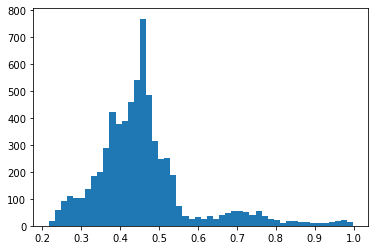

In [29]:
plt.hist(np.sum(probs[:, np.vectorize(lambda x: superpopulations_map[x])(ancestry_model.classes_) == 4][ukb_tg_projections.pred_superpopulation==4], axis=1), bins=50);

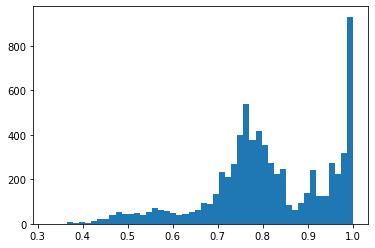

In [30]:
plt.hist(np.sum(probs[:, np.vectorize(lambda x: superpopulations_map[x])(ancestry_model.classes_) == 2][ukb_tg_projections.pred_superpopulation==2], axis=1), bins=50);

In [55]:
ukb_tg_projections.superpop_label.value_counts()

0                   447760
0 (below thresh)     13342
1                     9546
4 (below thresh)      6292
2                     5243
3                     2385
2 (below thresh)      2066
1 (below thresh)      1110
3 (below thresh)       329
4                      304
Name: superpop_label, dtype: int64

In [53]:
px.scatter(ukb_tg_projections, x='SCORE1_AVG', y='SCORE2_AVG', color='superpop_label').write_html('superpopulations_pc1v2_thresh.html')

In [54]:
px.scatter(ukb_tg_projections, x='SCORE3_AVG', y='SCORE4_AVG', color='superpop_label').write_html('superpopulations_pc3v4_thresh.html')